# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, substring, col, when, desc, min, max, sum, \
split, udf, count, countDistinct, rand, struct, isnan, isnull, from_unixtime, dayofmonth, month, datediff, to_date, lit, current_date
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime



In [3]:
# Create the spark session and load the dataframe
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn Analysis") \
    .getOrCreate()




# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.persist()

df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#Create a View
df.createOrReplaceTempView('logs')

In [7]:
#Let us see the Missing Values
print("Total Count: ", df.count())
print("Missing Value in Columns :- ")
for colName, dtype in df.dtypes:
    print(colName,':', df.filter(df[colName].isNull()).count())
    

Total Count:  286500
Missing Value in Columns :- 
artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


In [8]:
df.count()/df.filter(df["registration"].isNull()).count()

34.32782171099928

**Observations on Missing Values**
1. As we can see few columns as no missing values, user id is an unique attribute and it has no missing values
2. Columns like artist firstname, lastname, gender, length, location, registration, song and userAgent has missing values

Lets us how the missing values in firstname, lastname, artist impacts the model and which columns to be dropped.

In [9]:

df.filter(df.registration.isNull()).show(1,False)

print("Number of rows with missing registration: ", df.filter(df.registration.isNull()).count())
print("Number of rows with missing registration, name, gender, location and user agent: ",\
      df.filter(df.registration.isNull() & df.firstName.isNull() & df.lastName.isNull() &
               df.gender.isNull() & df.location.isNull() & df.userAgent.isNull()).count()) 

df = df.filter(df.registration.isNotNull())

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|auth      |firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|ts           |userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|null  |Logged Out|null     |null  |100          |null    |null  |free |null    |GET   |Home|null        |8        |null|200   |1538355745000|null     |      |
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
only showing top 1 row

Number of rows with missing registration:  8346
Number of rows with missing registration, name, gender, location and user agent:  8346


In [10]:
# Explore missing values in the artist column
df.where(col('artist').isNull()).show(10)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

These are all missing at the same row - where the user is not logged in. So as we can't identify these users individually and they constitute just ~3% of the records we drop the rows where registration is 0.

Total Records : 286500

Missing Registration: 8346

% Missing Registration : 2.91%

First name and last name aren't that useful
Auth has no variability - all users are logged in
We can user id to uniquely identify a user - so registration number isn't needed


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
# Visualize all the events and their associated counts
df.groupBy('Page').count().show()

+--------------------+------+
|                Page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [12]:
# N of unique users are present in this dataset
spark.sql('SELECT COUNT(DISTINCT userId) AS unique_users FROM logs').show()

+------------+
|unique_users|
+------------+
|         226|
+------------+



In [13]:
spark.sql('SELECT DISTINCT userId, 1 as churn FROM logs WHERE Page = "Cancellation Confirmation"').show(10)

+------+-----+
|userId|churn|
+------+-----+
|100005|    1|
|300007|    1|
|100011|    1|
|100012|    1|
|   101|    1|
|100014|    1|
|200001|    1|
|   105|    1|
|     3|    1|
|100023|    1|
+------+-----+
only showing top 10 rows



In [14]:
#creating a dataset will churn & no churn
#Dataset for users who churned
churn = spark.sql('SELECT DISTINCT userId, 1 as churn FROM logs WHERE Page = "Cancellation Confirmation"')

#Dataset for user who have no-churn
no_churn = spark.sql('SELECT DISTINCT userId, 0 as churn FROM logs \
                      WHERE userId NOT IN (SELECT DISTINCT userId FROM logs WHERE Page = "Cancellation Confirmation")')


In [15]:
# Create a dataframe from the union of the two, shuffling the rows
churn_df = churn.union(no_churn)
# Create a view 
churn_df.createOrReplaceTempView('churn')
churn_df = spark.sql('SELECT * FROM churn ORDER BY RAND()')
churn_df.createOrReplaceTempView('churn')

# Check that we have the right number of users
churn_df.count()


226

In [16]:
# converting to pandas to see the spread of users between churning or not
churn_pd_df = churn_df.toPandas()
churn_pd_df.groupby('churn', as_index=False).count()

,churn,userId
0,0,174
1,1,52


- We define churn at the user ID level by finding "cancellation confirmation" events 
- Then creating an indicator that a user, at any time in its history, will churn. 
- This approach allows us to study behavior prior to churning to try and build a predictive model and extract behaviors that indicate a risk of churning in the future.
- Also it is important to note that our dataset has a class imbalance, containing more than 3 times as many users who did not churn. We will need to keep this in mind when building our model and use some up- or downsampling techniques.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [17]:
# Join our churn dataset to our full dataset to add a column
joined_df = df.join(churn_df, on='userId')

# Use this column to create some aggregates, first comparing the level of the account
joined_df.groupBy(['churn', 'level']).count().show(10)

+-----+-----+------+
|churn|level| count|
+-----+-----+------+
|    0| free| 43333|
|    0| paid|189957|
|    1| paid| 32476|
|    1| free| 12388|
+-----+-----+------+



In [18]:
#Function to plot charts
def sns_barchart(data_dict):
    '''
    Function to plot to sns barchart
    Input: dictionary objects for the graph, x & y axis, data, hue and titles
    Output: plot a bar graph
    '''
    g = sns.barplot(x=data_dict['x'], y=data_dict['y'], hue=data_dict['hue'], data=data_dict['df'],
                palette="muted")
    g.set(xlabel=data_dict['x_label'], ylabel=data_dict['y_label'])
    plt.title(data_dict['title'])
    plt.show();

def sns_facet(data_dict):
    '''
    Function to plot sns facet grid
    Input: dictionary object for the graph
    Output: plot sns facetgrid
    '''
    g = sns.FacetGrid(data_dict["df"], col=data_dict["col"], sharey=False)
    g.map(plt.hist, data_dict["data"]);

In [19]:
# Build a data visualization on propotion of churn vs not chrun
level_df = joined_df.groupBy(['churn', 'level']).count().toPandas()
churn_sum = level_df.groupby('churn', as_index=False).sum()
level_df['proportion'] = (level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count_1']/level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count'])*100

In [20]:
#create dictionary object to plot graph
chart_data = {}
chart_data["x"] = "churn"
chart_data["y"] = "proportion"
chart_data["hue"] = "level"
chart_data["df"] = level_df
chart_data["x_label"]="Churn"
chart_data["y_label"]="Tier Proportion (in %)"
chart_data["title"]="Proportions of Churn"

In [21]:
print(chart_data)

{'x': 'churn', 'y': 'proportion', 'hue': 'level', 'df':    churn level   count  proportion
0      0  free   43333   18.574735
1      0  paid  189957   81.425265
2      1  paid   32476   72.387660
3      1  free   12388   27.612340, 'x_label': 'Churn', 'y_label': 'Tier Proportion (in %)', 'title': 'Proportions of Churn'}


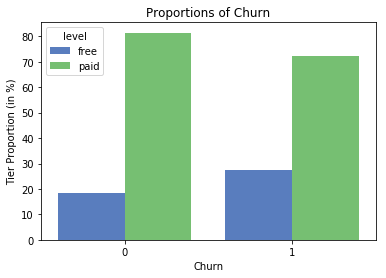

In [22]:
sns_barchart(chart_data)

In [23]:
# get the average length for every user, keeping the churn information and transform to a Pandas dataframe
length_df = joined_df.groupBy(['userId', 'churn']).avg('length').toPandas()

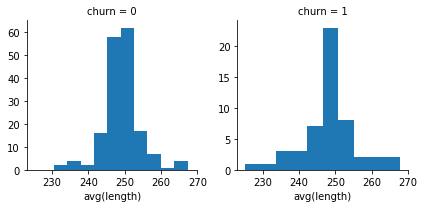

In [24]:
#Data Viz for thr Avg Length
facet_dict={}
facet_dict['df']=length_df
facet_dict['col']="churn"
facet_dict['data']="avg(length)"
sns_facet(facet_dict)

In [25]:
# The itemInSession variable, which represents the rank fo the song in the current sessionk
joined_df.groupBy('churn').avg('itemInSession').show()

+-----+------------------+
|churn|avg(itemInSession)|
+-----+------------------+
|    1|109.23299304564907|
|    0| 115.9888465000643|
+-----+------------------+



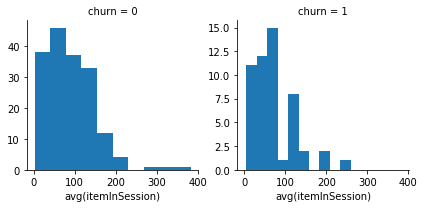

In [26]:
# Let us visualize the distribution between both groups
item_df = joined_df.groupBy(['userId','churn']).avg('itemInSession').toPandas()

facet_dict={}
facet_dict['df']=item_df
facet_dict['col']="churn"
facet_dict['data']="avg(itemInSession)"
sns_facet(facet_dict)


In [27]:
# Let's create a variable representing the state
joined_df = joined_df.withColumn('state', substring(col("location"), -2, 3))

# See the most present states for people who churned 
joined_df.groupBy(['churn', 'state']).count().where(joined_df['churn'] == 0).sort(col('count').desc()).show(5)
joined_df.groupBy(['churn', 'state']).count().where(joined_df['churn'] == 1).sort(col('count').desc()).show(5)

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    0|   CA|39158|
|    0|   PA|23708|
|    0|   TX|22200|
|    0|   NH|18637|
|    0|   FL|11427|
+-----+-----+-----+
only showing top 5 rows

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    1|   CA| 7613|
|    1|   CO| 4317|
|    1|   MS| 3839|
|    1|   WA| 3526|
|    1|   OH| 3173|
+-----+-----+-----+
only showing top 5 rows



In [28]:
# Study potential differences based on ts
joined_df.groupBy('churn').avg('ts').show(5)

+-----+--------------------+
|churn|             avg(ts)|
+-----+--------------------+
|    1|1.539919263874465E12|
|    0|1.541158850823305...|
+-----+--------------------+



In [29]:
# the ts column is actually a unix timestamp, which we convert to a date format
joined_df = joined_df.withColumn('date', from_unixtime((col('ts')/1000)).cast(DateType()))

In [30]:
# we can create some time based features
# first, extract day and month from the date column
joined_df = joined_df.withColumn('day', dayofmonth('date')).withColumn('month', month('date'))

# then for a given user get the average number of distinct sessions per day and per month
day_df = joined_df.groupBy(['userId', 'day']).agg(countDistinct('sessionId')).groupBy('userId').avg('count(DISTINCT sessionId)') \
                  .withColumnRenamed('avg(count(DISTINCT sessionId))', 'daily_sessions')
month_df = joined_df.groupBy(['userId', 'month']).agg(countDistinct('sessionId')).groupBy('userId').avg('count(DISTINCT sessionId)') \
                  .withColumnRenamed('avg(count(DISTINCT sessionId))', 'monthly_sessions')

# join this information back to the original joined_df for each row for a given userId, it will be used later
joined_df = joined_df.join(day_df, on='userId').join(month_df, on='userId')

In [31]:
# Compare number of daily and monthly sessions for the two groups of users
joined_df.groupBy('churn').avg('daily_sessions').show()
joined_df.groupBy('churn').avg('monthly_sessions').show()

+-----+-------------------+
|churn|avg(daily_sessions)|
+-----+-------------------+
|    1|  1.427520820895794|
|    0| 1.6932722878596427|
+-----+-------------------+

+-----+---------------------+
|churn|avg(monthly_sessions)|
+-----+---------------------+
|    1|   10.472394347360913|
|    0|   14.987535542315017|
+-----+---------------------+



In [32]:
# registration is also unix timestamp, representing the registration date. Convert them to an actual date
joined_df = joined_df.withColumn('registration_date', from_unixtime((col('registration')/1000)).cast(DateType()))

# create a new feature capturing the number of days since registration
joined_df = joined_df.withColumn('days_since_registration', datediff(current_date(), col('registration_date')))

# create a new feature capturing the month of the year when they registered, to account for potential promotions
joined_df = joined_df.withColumn('month_registration', month('registration_date'))

In [33]:
# Study potential differences based on user agent
joined_df.groupBy(['churn', 'userAgent']).count().where(joined_df['churn'] == 0).sort(col('count').desc()).show(5)
joined_df.groupBy(['churn', 'userAgent']).count().where(joined_df['churn'] == 1).sort(col('count').desc()).show(5)

+-----+--------------------+-----+
|churn|           userAgent|count|
+-----+--------------------+-----+
|    0|"Mozilla/5.0 (Win...|18226|
|    0|"Mozilla/5.0 (Mac...|16298|
|    0|"Mozilla/5.0 (Mac...|15914|
|    0|"Mozilla/5.0 (Win...|15237|
|    0|Mozilla/5.0 (Wind...|15224|
+-----+--------------------+-----+
only showing top 5 rows

+-----+--------------------+-----+
|churn|           userAgent|count|
+-----+--------------------+-----+
|    1|"Mozilla/5.0 (Mac...| 4736|
|    1|"Mozilla/5.0 (Win...| 4525|
|    1|Mozilla/5.0 (Wind...| 3437|
|    1|"Mozilla/5.0 (Mac...| 2534|
|    1|Mozilla/5.0 (Maci...| 2462|
+-----+--------------------+-----+
only showing top 5 rows



In [34]:
# For a given user we compute number of downgrades, upgrades, thumbs up, thumbs down, add friend, add to playlist, roll advert

# Create a column for each of these events, with a 1 each time they occur
for c in ['Downgrade', 'Roll Advert', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Thumbs Up']:
    joined_df = joined_df.withColumn(c, (joined_df['Page'] == c).cast(IntegerType()))
    
# Prepare data for the pipeline
features_df = joined_df.groupBy('userId').agg(avg('itemInSession'), 
                                              avg('length'),
                                              min('daily_sessions'),
                                              min('monthly_sessions'),
                                              min('days_since_registration'),
                                              min('month_registration'),
                                            max('level'), 
                                            max('userAgent'),
                                           max('state'),
                                           sum('Downgrade'),
                                           sum('Roll Advert'),
                                           sum('Thumbs Down'),
                                           sum('Add to Playlist'),
                                           sum('Add Friend'),
                                           sum('Thumbs Up'),
                                           max('churn'))

features_df = features_df.select(col('avg(itemInSession)').alias('itemInSession'),
                                 col('avg(length)').alias('length'),
                                 col('min(daily_sessions)').alias('daily_sessions'),
                                 col('min(monthly_sessions)').alias('monthly_sessions'),
                                 col('min(days_since_registration)').alias('days_since_registration'),
                                 col('min(month_registration)').alias('month_registration'),
                  col('max(level)').alias('level'),
                  col('max(userAgent)').alias('userAgent'),
                  col('max(state)').alias('state'),
                  col('sum(Downgrade)').alias('downgrade'),
                  col('sum(Roll Advert)').alias('rollAdvert'),
                  col('sum(Thumbs Down)').alias('thumbsDown'),
                  col('sum(Add to Playlist)').alias('addToPlaylist'),
                  col('sum(Add Friend)').alias('addFriend'),
                  col('sum(Thumbs Up)').alias('thumbsUp'),
                  col('max(churn)').alias('label'))

In [35]:
# Visualize the presence of potential null values
features_df.select([count(when(isnull(c), c)).alias(c) for c in features_df.columns]).show()

# Remove these null values
features_df = features_df.where(col("userAgent").isNotNull()).where(col("state").isNotNull())

+-------------+------+--------------+----------------+-----------------------+------------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+
|itemInSession|length|daily_sessions|monthly_sessions|days_since_registration|month_registration|level|userAgent|state|downgrade|rollAdvert|thumbsDown|addToPlaylist|addFriend|thumbsUp|label|
+-------------+------+--------------+----------------+-----------------------+------------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+
|            0|     0|             0|               0|                      0|                 0|    0|        0|    0|        0|         0|         0|            0|        0|       0|    0|
+-------------+------+--------------+----------------+-----------------------+------------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+



After studying distribution of various features between users who churned and those who did not, we choose these specific features for our model:

- Although on average the length is the same, digging into the distribution between these two groups shows some slight differences so we include this feature in our model
- We include item in session (which loosely translates to the number of songs per session) in our model
- The tier free/paid (18.6% free for people who churned vs. 27.6% free for people who not churned) 
- The state appear to provide information as to whether a user will churn or not
- Converting the unix "ts" timestamp, we are able to create the avg no of session per day and per month, both these features vary between the groups and we can consider this as a feature for our model
- similarly, registration is a unix timestamp capturing the registration date. We use it to engineer two new features for our model: the number of days since registration (the thinking here is that a longer tenure might indicate a lower probability of churning) and the registration month (the thinking being some months might be indicative of promotions and hence less loyal users)


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [36]:
#Create Pipeline
indexer_state = StringIndexer(inputCol='state', outputCol='state_index')
indexer_level = StringIndexer(inputCol='level', outputCol='level_index')
indexer_ua = StringIndexer(inputCol='userAgent', outputCol='userAgent_index')
assembler = VectorAssembler(inputCols=['itemInSession', 
                                       'length',
                                       'daily_sessions',
                                       'monthly_sessions',
                                       'days_since_registration',
                                       'month_registration',
                                       'level_index', 
                                       'state_index',
                                       'userAgent_index',
                                       'downgrade',
                                       'rollAdvert',
                                       'thumbsDown',
                                       'addToPlaylist',
                                       'addFriend',
                                       'thumbsUp'],
                           outputCol='features')
features_pipeline = Pipeline(stages=[indexer_state, indexer_level, indexer_ua, assembler])

model_df = features_pipeline.fit(features_df).transform(features_df)

In [37]:
#structure the data from sparse to dense
df2 = model_df.select("label", "features")
rdd = df2.rdd.map(lambda x: Row(label=x[0],features=DenseVector(x[1].toArray()))
                     if (len(x)>1 and hasattr(x[1], "toArray"))
                     else Row(label=None, features=DenseVector([])))
model_data = spark.createDataFrame(rdd)

In [38]:
# Create a function to train and estimate a model
def fit_estimate(train, test, model):
    '''
    INPUTS:
    train (Spark df): a Spark data frame with training data
    test (Spark df): a Spark data frame with testing data
    model (string): a string designating one of the models to fit, either 'logistic_regression', 'random_forest' 
                    or 'gradient_boosting'
    
    OUTPUT:
    None, prints out accuracy for the model
    
    DESCRIPTION:
    Fits and estimates different classification models with the default parameters
    '''
    # Choose the model
    if model == 'logistic_regression':
        ml = LogisticRegression()
    elif model == 'random_forest':
        ml = RandomForestClassifier()
    elif model == 'gradient_boosting':
        ml = GBTClassifier()
    else:
        return "Please choose an appropriate model"
    
    # Fit and calculate predictions
    classification = ml.fit(train)
    results = classification.transform(test)
    
    # Calculate accuracy and F-1 score
    accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy = accuracy_evaluator.evaluate(results.select(col('label'), col('prediction')))
    
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
    
    print('For {}, the accuracy on the test set is {:.2%} and the F-1 score is {}'\
    .format(model, accuracy, f1_score))

In [39]:
# Split this data between train, validation and test sets
train, test = model_data.randomSplit([0.8, 0.2], seed=42)

# Due to the class imbalance, we upsample the categories who churned in the training dataset
print('In our training set, before upsampling we have {} users who churned and {} who did not.'.format(train.where(col('label') == 1).count(),
                                                                                           train.where(col('label') == 0).count()))

train_churn = train.where(col('label') == 1).sample(True, train.where(col('label') == 0).count()/train.where(col('label') == 1).count())
train_no_churn = train.where(col('label') == 0)
train = train_churn.unionAll(train_no_churn)

In our training set, before upsampling we have 41 users who churned and 150 who did not.


In [44]:

# Fit various models and visualize their accuracies
for model in ['logistic_regression', 'random_forest', 'gradient_boosting']:
    fit_estimate(train, test, model)

For logistic_regression, the accuracy on the test set is 61.76% and the F-1 score is 0.6272503419972639
For random_forest, the accuracy on the test set is 73.53% and the F-1 score is 0.72249952612624
For gradient_boosting, the accuracy on the test set is 67.65% and the F-1 score is 0.6608327541542932


Let us go with Random forest and optimize further since it performs best both in terms of accuracy and F1 score, and it quite fast to train.


In [40]:
# Optimize a Random Forest model through Grid Search
model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.minInfoGain, [0, 1]) \
    .addGrid(model.numTrees, [20, 50]) \
    .addGrid(model.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator = Pipeline(stages=[model]),
                         estimatorParamMaps = param_grid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

classification = crossval.fit(train)
results = classification.transform(test)

# Calculate accuracy and F-1 score
accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(results.select(col('label'), col('prediction')))

f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))

print('For {}, the accuracy on the test set is {:.2%} and the F-1 score is {}'\
.format(model, accuracy, f1_score))

For RandomForestClassifier_72d714ba6fd0, the accuracy on the test set is 67.65% and the F-1 score is 0.5459236326109391


In [41]:
# Examine feature importance
DenseVector(classification.bestModel.stages[-1].featureImportances)

DenseVector([0.0994, 0.0747, 0.0735, 0.0658, 0.0769, 0.0274, 0.0088, 0.0647, 0.0547, 0.0591, 0.0627, 0.0593, 0.0692, 0.1093, 0.0946])

**Summary on Steps we accomplished**

1. Converted all our features into numeric by creating a pipeline.
2. Upsampled the "churn" category in our training dataset due to the class imbalance in our dataset.
3. Created a Machinlearning pipeline to train and evaluate the model
4. Trained the data with three different algorithm, a)Logstic Regression b)Random Forest c)Gradient boosting
5. we selected Random forest to optimize further as it was having very good F1 score and accuracy
6. The hyparameter tunning resulted in 

**Conclusion**
We have created powerful model, which flag the peopple "at risk" for not churning out. Which helps the company to target those customer and send personlized offers and discounts to retain the customer, thus improving revenue and growth of the Sparkify.
It is important that this model be re-trained regularly to avoid making decisions on outdated data as the user base and consumer behavior evolve. 
For instance, the model could be run every day (or week depending on the computing infrastructure) and once a user is flagged as likely to churn, personalized messages or discounts could be sent. 
sparkify can also use A/B testing to ensure rigor and statistical significance, to improve the chrun rate and campaign click thru rate. which reduces the cost spend on the ads. 


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.